# Numerical Matrix Methods for the Tilted Potential Well 

Version 0.0.1, 2023 January 17

Hello! This Jupyter notebook will guide you through how matrix methods and the basis states of the infinite potential well can be used to numerically solve the tilted potential well. We will represent our Hamiltonian in the basis of eigenstates of the infinite potential well, then use matrix diagonalization to find our eigenstates and eigenvalues. By truncating our basis to the first $N$ elements, we can obtain an accurate approximate solution to the tilted potential well. For further reading, you are welcome to read the associated paper [here](). For any questions, comments and suggestions, please email rafiullah@lums.edu.pk

This tutorial assumes some basic familiarity with Python and a few commonly used libraries such as NumPy and matplotlib. For some quick references to get acquainted with these, the [Python tutorial](https://docs.python.org/3/tutorial/) and [NumPy quickstart guide](https://numpy.org/doc/stable/user/quickstart.html) are very useful.

In [1]:
#Here we import some standard Python libraries and functions for numerical computing
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.integrate import quad
from scipy.stats import cauchy

#The following line makes sure our matplotlib graphs appear in our notebook
%matplotlib inline 



#The following lines update matplotlib parameters to use LaTeX fonts, allowing us to produce 
#publication quality figures directly in our IPython notebook without additional processing
params = {'text.latex.preamble' : r'\usepackage{lmodern}',
          'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

#We also define the following function which allows us to print matrices in a readable format
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Setup and parameters

Here, we set the parameters of the system we are using. Here, ${e\_ not}$ is the strength of the electric field, $a$ is the width of the potential well, $m$ is the mass of the particle, $q$ is the charge of the particle. All parameters here are in Hartree atomic units. A handy list of atomic units with values in SI included can be found [here](https://en.wikipedia.org/wiki/Hartree_atomic_units#Units).

$noOfStates$ is the number of basis states $N$ that will be used to expand the eigenstates of the new Hamiltonian, and changing this to a higher or lower value allows us to control our level of approximation.

In [2]:
e_not = 0.1
a = 10
mass = 1  
q = 1   
hbar = 1

noOfStates = 200

# Setting up our basis
We will represent our Hamiltonian in the basis states $\phi_n(x)$ of the infinite potential well, each with energy $E(n)$. So, we define these as Python functions to aid our future calculations.

In [3]:
#These are energy eigenvalues of the infinite potential well
def E(n): 
    return (n**2)*((np.pi)**2)/(2*mass*(a**2))
#These are the eigenstates of the infinite potential well corresponding to the nth eigenstate
def phi(n,x):
    return np.sqrt(2/a)*np.sin(n*np.pi*x/a)


#Here we just store the eigenvalues of the first N states, for future comparisons
OriginalEnergies = np.zeros(noOfStates)
for i in range(noOfStates):
    OriginalEnergies[i] = E(i+1)

# Setting up the tilted potential well

Since our basis set $\phi_n(x)$ is complete, we can write any Hamiltonian in terms of this basis and completely characterize it by consider all the possible the matrix elements $H_{nm}$ which can be written as
$$ 
H_{nm} = \int_0^a \phi_n(x) \hat{H} \phi_m(x).
$$

This allows us to reframe the tilted well problem as a matrix eigenvalue problem in terms of the basis set of the infinite potential well. The tilted well Hamiltonian can be written (in position space) as 
$$ \hat{H} = -\frac{\hbar^2}{2m}\frac{\partial}{\partial x} + e\mathcal{E}x $$
in the domain $0 < x < a$ and infinite otherwise.

We can then easily use this to calculate the matrix elements, which look like
$$ H_{nm} = \begin{cases}
    E_n + \mathcal{E}\left(\frac{a}{2}\right) & \text{if } m=n,\\
    \frac{-8a\mathcal{E}}{\pi^2}\left(\frac{mn}{(m^2-n^2)^2}\right) & \text{if } m + n \text{ odd},\\
    0 & \text{otherwise.}
  \end{cases}
$$

In this section, we set the tilted well Hamiltonian up by using its representation as these matrix elements and then populating an $N \times N$ matrix with these elements. We will then use this matrix for our eigenvalue and eigenvector calculations. It is important to note that since we are only condsidering a finite dimension for the matrix, we are essentially making an approximation by truncating our basis.

In [19]:
#We write a function to represent the Hamiltonian in terms of its basis elements
def H(n, m):
    if (m == n):
        return E(n) + e_not*(a/2)
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -e_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)
    
    
#The following code generates a matrix from the above function.
vH = np.vectorize(H) #This step allows us to use NumPy function reserved for vectorized functions
HMatrix = np.fromfunction(vH, (noOfStates+1, noOfStates+1)) #This will generate a matrix using the matrix elements from 0 to N

#However, we typically number our eigenstates for the infinite potential well starting from the 1st eigenstate
#So we disregard the first row and column which contain false references to the "0"th eigenvalue
HMatrix = HMatrix[1:noOfStates+1, 1:noOfStates+1]

# Finding Eigenstates and Eigenvalues
Next we obtain the eigenvalues and eigenvectors of the constructed matrix. The eigenvalues represent the energies of the new system, while the eigenvectors represent the corresponding eigenstates. 

In [20]:
#This function finds the eigenvalues and eigenvectors of a matrix A and then sorts them by their eigenvalue, in an ascending order
def SortedEigen(A):
    #We use the eigh function which can be used for Hermitian matrices
    eigenValues, eigenVectors = linalg.eigh(A)
    
    #We sort the eigenvalues and vectors via the NumPy argsort function
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    return (eigenValues, eigenVectors)

In [6]:
#We use the above defined function to calculate the eigenstates and eigenvalues. This is where the majority of our computation happens
EnergiesH, EigenvectorsH = SortedEigen(HMatrix)

In [21]:
#We define our eigenstates as a linear combination of the states given by phi_n
def psi(n, x):
    val = 0
    for i in range(noOfStates):
        val += EigenvectorsH[i,n-1]*phi(i+1,x)
    return val

# Plotting our new wavefunctions
Now, we will create some simple plots to examine how the presence of the tilt in our well affects our eigenstates. The following code can be used to plot the $n^{th}$ eigenstate, and visually see how are wavefunction changes.

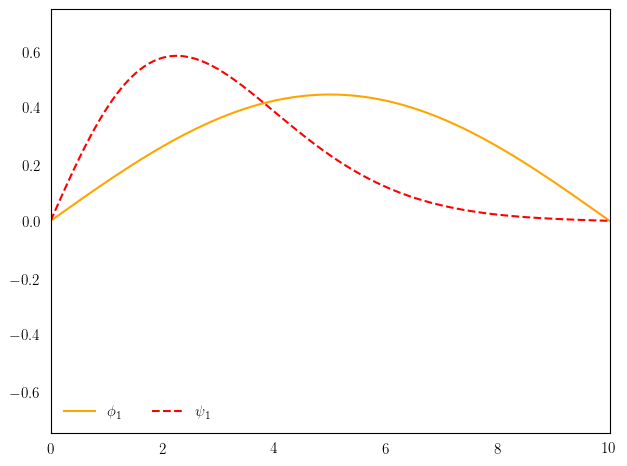

In [31]:
import matplotlib.ticker as plticker
x = np.linspace(0, a, 1000)

n = 1
fig, ax = plt.subplots()

ax.set_xlim(0,a)
ax.set_ylim((-0.75,0.75))

y = psi(n,x)
z = phi(n,x)
ax.plot(x,z, color='orange',label='$\phi_{%i}$' %(n))
ax.plot(x,y, '--r',label='$\psi_{%i}$' %(n))
ax.legend(loc = 'lower left', fancybox=True, framealpha=0.0,ncol=2)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.tight_layout()


# Exercise
As a quick exercise, you are invited to play around with the above plots a bit. Change any parameters you wish to. In particular, what happens if you keep decreasing the tilt of the well (without setting it to 0)? What happens if you make it incredibly large? What if we change the size of the well? Are different eigenstates affected differently? Try to think about what you think should happen and whether your guess matches with reality.

# Plotting probability densities


In [8]:
#Calculating Matrix Elements:

f_not = 1

def V(x): 
    return (x-a/2)

def Helper(x,m,n):
    return phi(m,x)*V(x)*phi(n,x)

def Vmn(m,n):
    res, err = quad(Helper,0,a, args=(m,n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0

def DipoleCouplingStrength(n, m):
    if (m == n):
        return 0
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -f_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)
    
vdcs = np.vectorize(DipoleCouplingStrength)
vdcscomp = np.vectorize(Vmn)


In [9]:
def Helper2(x,m,n):
    return psi(m,x)*V(x)*psi(n,x)

def Vmn2(m,n):
    res, err = quad(Helper2,0,a, args=(m,n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0

In [10]:
length = 10


DipoleStrengthMatrix = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrix[i-1,j-1] = DipoleCouplingStrength(i,j)


DipoleStrengthMatrixComp = np.fromfunction(vdcscomp, ((length +1), (length+1)))
DipoleStrengthMatrixComp = DipoleStrengthMatrixComp[1:(length + 1), 1:(length + 1)]

DipoleStrengthMatrixPerturb = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrixPerturb[i-1,j-1] = Vmn2(i,j)

        
DipoleStrengthMatrix = np.absolute(DipoleStrengthMatrix)
DipoleStrengthMatrixPerturb = np.absolute(DipoleStrengthMatrixPerturb)

DipoleStrengthMatrixCompDebye = DipoleStrengthMatrixComp*2.52


DipoleStrengthMatrixDebye = (DipoleStrengthMatrix)*2.52
DipoleStrengthMatrixPerturbDebye = (DipoleStrengthMatrixPerturb)*2.52

In [11]:
matprint(DipoleStrengthMatrixDebye)

        0    4.53919          0  0.363135         0  0.100047         0  0.0411718          0  0.0208411  
  4.53919          0    4.90232         0  0.463183         0  0.141219          0  0.0620129          0  
        0    4.90232          0   5.00237         0  0.504354         0    0.16206          0  0.0739996  
 0.363135          0    5.00237         0   5.04354         0  0.525195          0   0.174047          0  
        0   0.463183          0   5.04354         0   5.06438         0   0.537182          0   0.181568  
 0.100047          0   0.504354         0   5.06438         0   5.07637          0   0.544703          0  
        0   0.141219          0  0.525195         0   5.07637         0    5.08389          0   0.549729  
0.0411718          0    0.16206         0  0.537182         0   5.08389          0    5.08892          0  
        0  0.0620129          0  0.174047         0  0.544703         0    5.08892          0    5.09244  
0.0208411          0  0.0739996      

In [12]:
matprint(DipoleStrengthMatrixPerturbDebye)

  5.88457    2.82577   0.864381   0.430308    0.23315   0.143202  0.0898046  0.0623784  0.0430376  0.0323439  
  2.82577    1.05206    4.17341   0.851395   0.447301    0.17457   0.135974  0.0644483  0.0592369  0.0309791  
 0.864381    4.17341    1.18568    4.79943   0.497279   0.476693  0.0980436   0.150634   0.036664   0.068127  
 0.430308   0.851395    4.79943    1.14853    4.99215   0.291358   0.514139   0.058412   0.169085  0.0221504  
  0.23315   0.447301   0.497279    4.99215   0.801034    5.04967   0.193229   0.533228  0.0395214   0.179634  
 0.143202    0.17457   0.476693   0.291358    5.04967   0.569158    5.07118   0.138694   0.543096  0.0288681  
0.0898046   0.135974  0.0980436   0.514139   0.193229    5.07118   0.422515    5.08174   0.104773   0.548992  
0.0623784  0.0644483   0.150634   0.058412   0.533228   0.138694    5.08174   0.325496    5.08791  0.0820843  
0.0430376  0.0592369   0.036664   0.169085  0.0395214   0.543096   0.104773    5.08791   0.258263    5.09193  
0

In [13]:
np.fill_diagonal(DipoleStrengthMatrixPerturbDebye, 0)

In [14]:
matprint(DipoleStrengthMatrixPerturbDebye)

        0    2.82577   0.864381   0.430308    0.23315   0.143202  0.0898046  0.0623784  0.0430376  0.0323439  
  2.82577          0    4.17341   0.851395   0.447301    0.17457   0.135974  0.0644483  0.0592369  0.0309791  
 0.864381    4.17341          0    4.79943   0.497279   0.476693  0.0980436   0.150634   0.036664   0.068127  
 0.430308   0.851395    4.79943          0    4.99215   0.291358   0.514139   0.058412   0.169085  0.0221504  
  0.23315   0.447301   0.497279    4.99215          0    5.04967   0.193229   0.533228  0.0395214   0.179634  
 0.143202    0.17457   0.476693   0.291358    5.04967          0    5.07118   0.138694   0.543096  0.0288681  
0.0898046   0.135974  0.0980436   0.514139   0.193229    5.07118          0    5.08174   0.104773   0.548992  
0.0623784  0.0644483   0.150634   0.058412   0.533228   0.138694    5.08174          0    5.08791  0.0820843  
0.0430376  0.0592369   0.036664   0.169085  0.0395214   0.543096   0.104773    5.08791          0    5.09193  
0

In [15]:
def deviationOriginalWell(x,n):
    return phi(n,x)*x**2*phi(n,x)

def position(x,n):
    return psi(n,x)*x*psi(n,x)

def deviation(x,n):
    return psi(n,x)*x**2*psi(n,x)

def positionexpectation(n):
    res, err = quad(position,0,a, args=(n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0
    
def standardDeviation(n):
    pos, err = quad(position,0,a, args=(n,),limit=1000)
    dev,err = quad(deviation, 0,a, args =(n,), limit=1000)
    if (abs(dev)>=err):
        return np.sqrt(dev - pos**2)
    else:
        return 0
def standardDeviationOriginalWell(n):
    dev,err = quad(deviationOriginalWell, 0,a, args =(n,), limit=1000)
    if (abs(dev)>=err):
        return np.sqrt(dev - 5**2)
    else:
        return 0

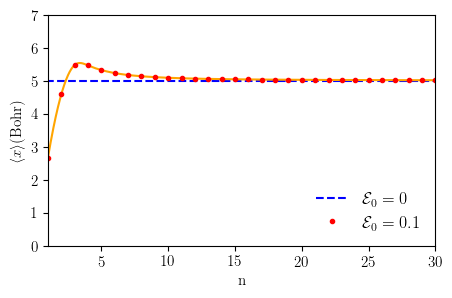

In [16]:
from scipy.interpolate import make_interp_spline, BSpline

j = 30

x = np.linspace(1,j,j)
x2 = np.linspace(0,j,j+1)

fig = plt.figure(figsize=(5,3), dpi= 100)
ax = fig.add_subplot(1, 1, 1)
y = np.zeros(len(x))
y2 = np.zeros(len(x2))

ax.plot(x2,y2+5,'--',color='blue', label="$\mathcal{E}_0 = 0$")

for i in range (1, j+1):
    y[i-1] = (positionexpectation(i))

xnew = np.linspace(1,j,1000)
spl = make_interp_spline(x,y,k=3)
position_smooth = spl(xnew)
ax.plot(xnew,position_smooth,color="orange")

ax.plot(x, y,'.r',label="$\mathcal{E}_0 = %g$"%e_not)
ax.set_xlabel('n')
ax.set_ylabel(r'$\langle x \rangle$(Bohr)')
ax.set_xlim(1,j)
ax.set_ylim(0,7)


ax.legend(loc = 'lower right', fontsize=12, fancybox=True, framealpha=0.0)


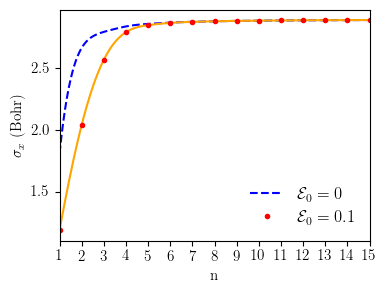

In [17]:
from scipy.interpolate import make_interp_spline, BSpline

x = np.linspace(1,15,15)
fig = plt.figure(figsize=(4,3), dpi= 100)
ax = fig.add_subplot(1, 1, 1)
y = np.zeros(len(x))
z = np.zeros(len(x))

for i in range (1, 16):
    z[i-1] = (standardDeviationOriginalWell(i))
xnew = np.linspace(1,15,1000)
spl = make_interp_spline(x,z,k=5)
deviation_smooth = spl(xnew)
ax.plot(xnew,deviation_smooth,"--",color="blue",label="$\mathcal{E}_0 = 0$")



for i in range (1, 16):
    y[i-1] = (standardDeviation(i))

xnew = np.linspace(1,15,1000)
spl = make_interp_spline(x,y,k=5)
deviation2_smooth = spl(xnew)
ax.plot(xnew,deviation2_smooth,color="orange")
ax.plot(x, y,'.r',label="$\mathcal{E}_0 = %g$"%e_not)

ax.set_xlabel('n')
ax.set_ylabel(r'$\sigma_x$ (Bohr)')
ax.set_xlim(1,15)
ax.set_xticks(x)


ax.legend(loc = 'lower right', fontsize=12, fancybox=True, framealpha=0.0)

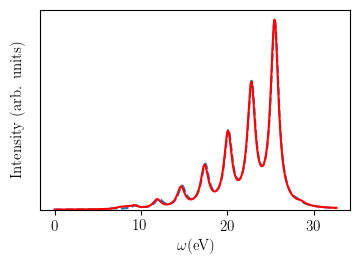

In [18]:
values  = np.zeros(shape=(length**2,2))
counter = 0
epsilon_not = 1
c = 1

length = 10

for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(OriginalEnergies[i-1] - OriginalEnergies[j-1])   
            I = ((DipoleStrengthMatrixDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            values[counter:counter+1] = [omega, I]
            counter += 1
    
values = values[0:counter]

values2  = np.zeros(shape=(length**2,2))
counter2 = 0

for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(EnergiesH[i-1] - EnergiesH[j-1])   
            I = ((DipoleStrengthMatrixDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            values2[counter2:counter2+1] = [omega, I]
            counter2 += 1
    
values2 = values2[0:counter2]

x = np.linspace(0,1.2, 1000)
y  = np.zeros(len(x))
y2  = np.zeros(len(x))


for k in range(len(values)):
    y += cauchy.pdf(x, values[k,0],0.02)*values[k,1]

for k in range(len(values2)):
    y2 += cauchy.pdf(x, values2[k,0],0.02)*values2[k,1]


xev = 27.2114 * x

fig = plt.figure(figsize=(4,2.6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.plot(xev, y,'--')
ax.plot(xev,y2, 'r')
ax.set_xlabel(r'$$\omega \textnormal{(eV)}$$')
ax.set_ylabel('Intensity (arb. units)')
ax.set_yticklabels([])
ax.set_ylim(0,)
ax.yaxis.set_ticks_position('none')
